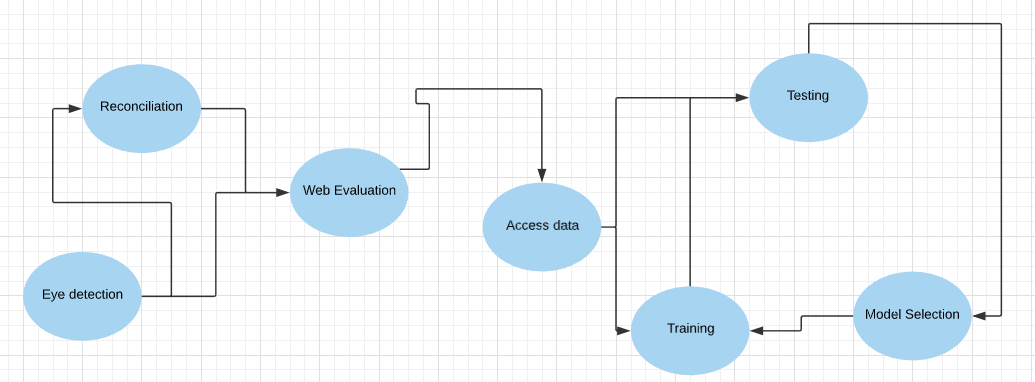

In [2]:
from IPython.display import Image as IpI
IpI("network.png")

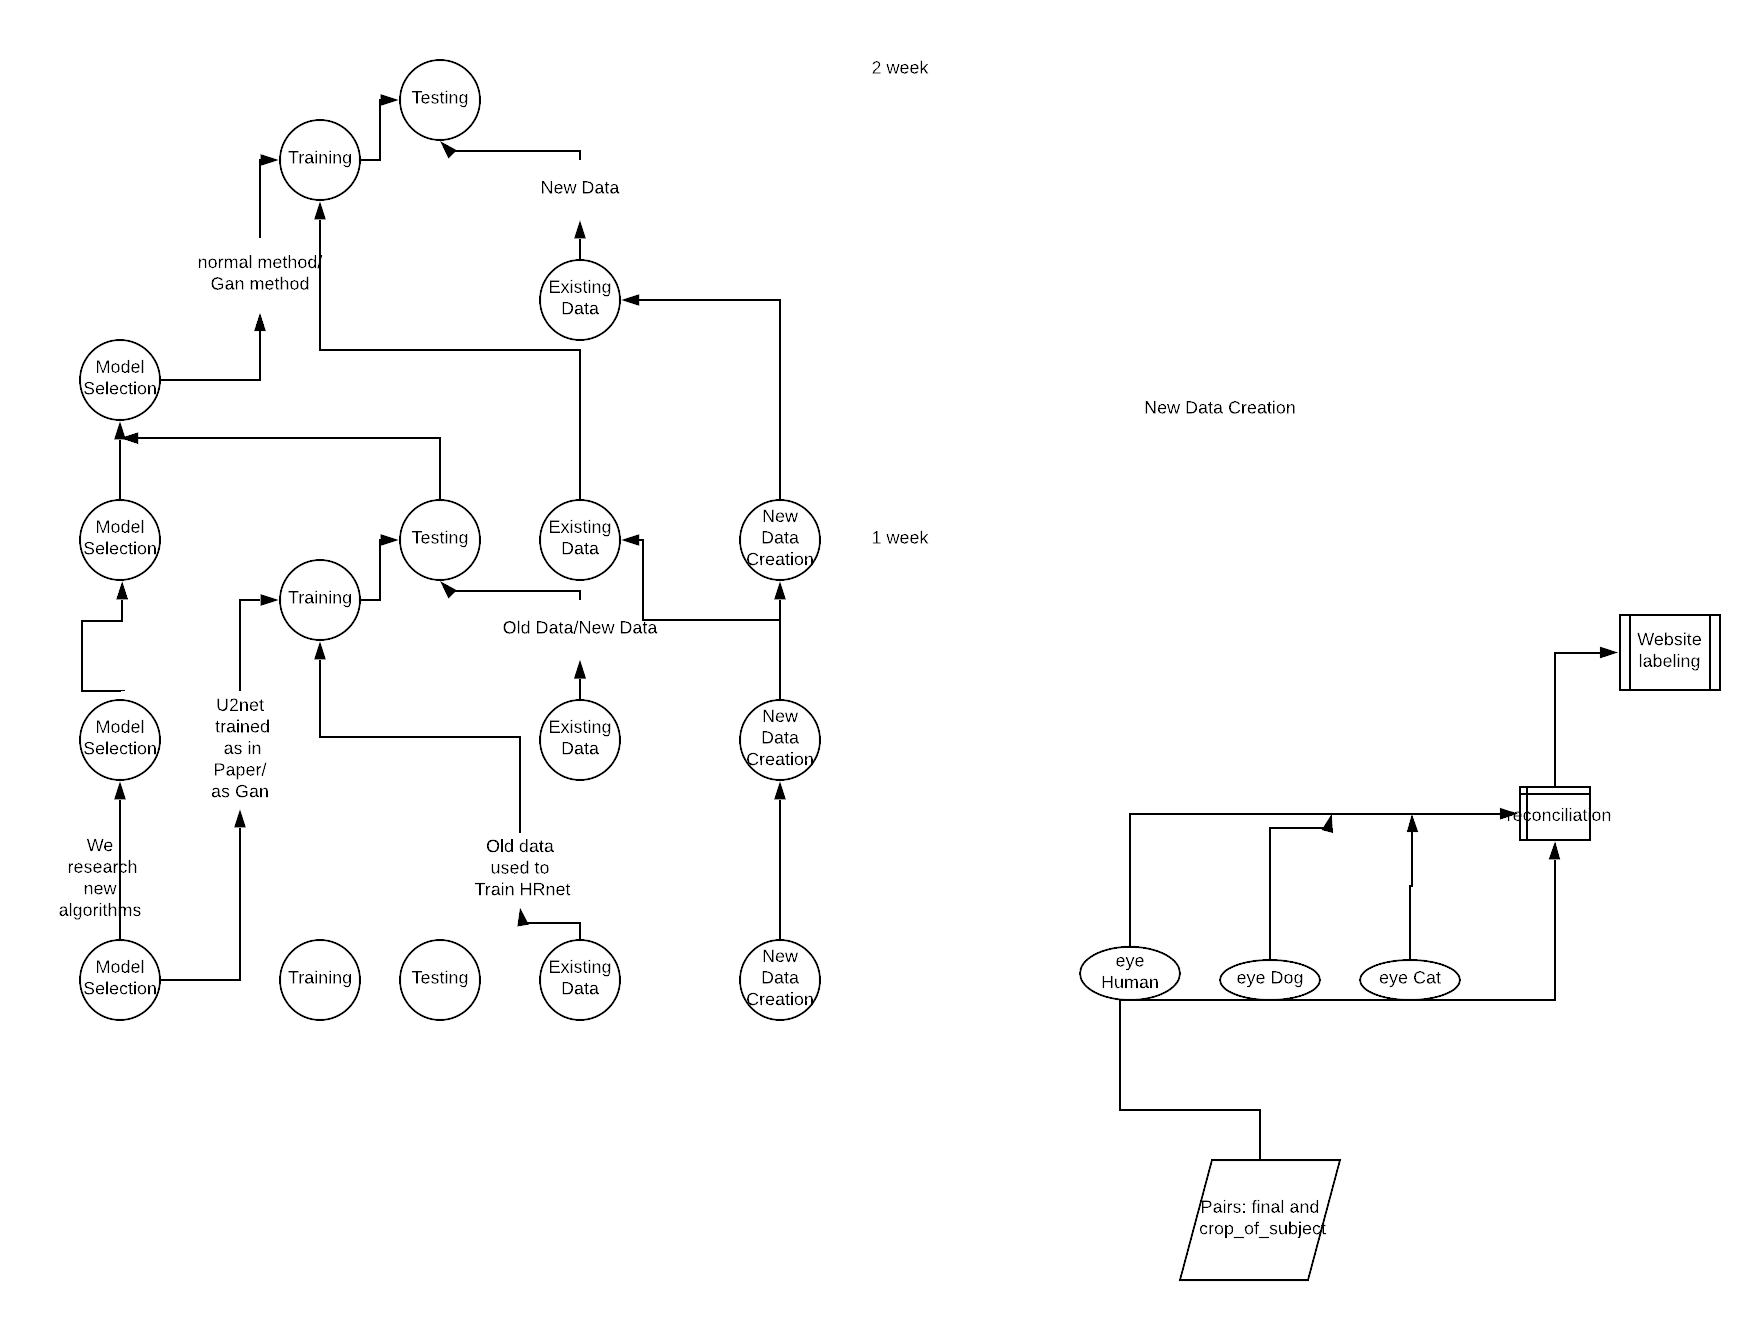

In [3]:
IpI("base_diagram.png")

Working Plan.

Two paths.




In [ ]:
Our new dataset is sufficiently different from the training dataset that a model performing on the old dataset may fail in our dataset. 

While we build the new dataset, we prepare the models.

First we take the data used to train the original model, and use it on u2net. We need to modify u2net and 

    - Modify u2net to use all 6 of it's channels (1~2 days).
    - Find training data (ask Eric).
    -- Train directly u2net (1~week).
    -- Train with pix2pix (1-2~ weeks  ask Ericd)

In parallel:

    -Research newer methods including updates to hrnet and smaller versions.

- Test on data similar to training data
- Test on newer data.
    
Estimated time to have both models trained (1~2 weeks).

### Data collection.
The new dataset has less noise as the images are centered around the face.

- Pair the final product and the crop of subject
- Use google's landmark, dog landmark[https://github.com/kairess/dog_face_detector] and  cat landmark[https://github.com/kairess/cat_hipsterizer] to create a first reconciliation based only on eyes.
- If needed, run reconciliation algorithm only for small dilations, and rotations.
- While U2net is being trained, evaluate the datasets created. 
- Train U2net on the new dataset, adding new data and evaluating performace.







'divvyup-data/newsci_dump-02082019.json' contains a json with one to one and many to one images
gs://newsci-lab-data/divvyup-json/mask_updates.csv contains mask that were reconciled by us, and we can trust
    can we run a u2net on them?
    can we run a u2net on them with pix2pix?
    

In [1]:
import pandas as pd

file = pd.read_csv('mask_updates.csv')    

In [2]:
file.head()

,mask_of_subjects_face,order_id,line_item_id,mask_quality,subject_class,number_of_heads
0,/refined_masks/mask_images3/mask_images2/14389...,20263,143893,good,dog,1
1,/refined_masks/mask_images3/mask_images2/14389...,20265,143895,good,dog,1
2,/refined_masks/mask_images3/mask_images2/14389...,20268,143896,good,dog,1
3,/refined_masks/mask_images3/mask_images2/14389...,20270,143897,bad,dog,1
4,/refined_masks/mask_images3/mask_images2/14390...,20273,143900,good,cat,1


In [3]:
good = file[file.mask_quality=='good']

In [4]:
good.describe()

,order_id,line_item_id,number_of_heads
count,2825.000000,2825.000000,2825.000000
mean,24226.029735,146773.384071,1.014867
std,2372.631124,1666.266034,0.154461
min,20263.000000,143893.000000,0.000000
25%,22200.000000,145324.000000,1.000000
50%,24221.000000,146811.000000,1.000000
75%,26179.000000,148189.000000,1.000000
max,42819.000000,149631.000000,4.000000


In [5]:
good.head()

,mask_of_subjects_face,order_id,line_item_id,mask_quality,subject_class,number_of_heads
0,/refined_masks/mask_images3/mask_images2/14389...,20263,143893,good,dog,1
1,/refined_masks/mask_images3/mask_images2/14389...,20265,143895,good,dog,1
2,/refined_masks/mask_images3/mask_images2/14389...,20268,143896,good,dog,1
4,/refined_masks/mask_images3/mask_images2/14390...,20273,143900,good,cat,1
5,/refined_masks/mask_images3/mask_images2/14390...,20275,143902,good,human,1


In [7]:
good.mask_of_subjects_face[0]

'/refined_masks/mask_images3/mask_images2/143893-20263-1539886090-84-1034e34e-75fe-4346-adc8-485ece94df1d.npy'

### On divvyup-data/line/orderid/cropped we can find the rgb files.
We grab them and test u2net on it.

In [11]:
json = pd.read_json('newsci_dump-02082019.json', dtype=True)

In [12]:
json.head()

,numPhotos,numHeads,data
0,409354,424575,"{'order_id': 142372, 'line_items': [{'line_ite..."
1,409354,424575,"{'order_id': 142373, 'line_items': [{'line_ite..."
2,409354,424575,"{'order_id': 142374, 'line_items': [{'line_ite..."
3,409354,424575,"{'order_id': 142375, 'line_items': [{'line_ite..."
4,409354,424575,"{'order_id': 142377, 'line_items': [{'line_ite..."


In [13]:
json.data[0]

{'order_id': 142372,
 'line_items': [{'line_item_id': 18186,
   'original_photos': ['142372/1539646443-68-img-0299.jpg',
    '142372/1539646443-63-img-20150315-153534.jpg',
    '142372/1539646443-68-pippy.png'],
   'approved_cropped_heads': ['142372/18186/cropped/30871',
    '142372/18186/cropped/30872',
    '142372/18186/cropped/30873']},
  {'line_item_id': 18187,
   'original_photos': ['142372/1539647680-19-img-0299.jpg',
    '142372/1539647680-34-img-20150315-153534.jpg',
    '142372/1539647680-4-pippy.png'],
   'approved_cropped_heads': ['142372/18187/cropped/30875',
    '142372/18187/cropped/30876',
    '142372/18187/cropped/30878']}]}

In [43]:
import json
# load data using Python JSON module
with open('newsci_dump-02082019.json','r') as f:
    stuff = json.loads(f.read())
# Flatten data
df_nested_list = pd.json_normalize(stuff, record_path =['data','line_items'])# we ignore order id

In [44]:
df_nested_list.head()

,line_item_id,original_photos,approved_cropped_heads
0,18186,"[142372/1539646443-68-img-0299.jpg, 142372/153...","[142372/18186/cropped/30871, 142372/18186/crop..."
1,18187,"[142372/1539647680-19-img-0299.jpg, 142372/153...","[142372/18187/cropped/30875, 142372/18187/crop..."
2,18188,[142373/1539648052-25-e4876618-3ddb-4da2-905a-...,[142373/18188/cropped/30865]
3,18189,[142374/1539648041-56-d5fde5db-87c2-42b6-b06a-...,[142374/18189/cropped/30869]
4,18190,[142374/1539648124-93-815b6acc-1b65-4c4d-8ab9-...,[142374/18190/cropped/30870]


In [45]:
assert len(df_nested_list)== len(df_nested_list.line_item_id.unique() )

In [46]:
 len(df_nested_list)

304431

In [47]:
assert len(good)== len(good.line_item_id.unique() )

AssertionError: 

In [48]:
 len(good)

2825

In [49]:
len(good.line_item_id.unique() )

2239

In [50]:
good[good.duplicated(['line_item_id'], keep=False)]

,mask_of_subjects_face,order_id,line_item_id,mask_quality,subject_class,number_of_heads
8,/refined_masks/mask_images3/mask_images2/14390...,20281,143906,good,dog,1
9,/refined_masks/mask_images3/mask_images2/14390...,20282,143906,good,dog,1
10,/refined_masks/mask_images3/mask_images2/14390...,20283,143906,good,cat,1
20,/refined_masks/mask_images3/mask_images2/14392...,20305,143922,good,dog,1
21,/refined_masks/mask_images3/mask_images2/14392...,20306,143922,good,dog,1
...,...,...,...,...,...,...
3915,/refined_masks/mask_images3/mask_images2/14960...,28272,149608,good,dog,1
3916,/refined_masks/mask_images3/mask_images2/14960...,28273,149608,good,dog,1
3917,/refined_masks/mask_images3/mask_images2/14960...,28274,149608,good,dog,1
3918,/refined_masks/mask_images3/mask_images2/14960...,28275,149609,good,dog,1


I want to remove those terms that have more than one entry

In [51]:
new_table =pd.concat(g for _, g in good.groupby('line_item_id') if len(g) == 1)

In [52]:
len(new_table)

1824

This are the initial images to run experiments, they are already aligned, with a perfect label, and ready to be used.

In [54]:
joined = pd.merge(df_nested_list,new_table, on='line_item_id')

In [55]:
len(joined)

1795

In [56]:
joined.describe()

,line_item_id,order_id,number_of_heads
count,1795.000000,1795.000000,1795.000000
mean,146722.295265,24161.810028,1.018384
std,1664.364038,2398.358989,0.157307
min,143893.000000,20263.000000,0.000000
25%,145281.500000,22144.000000,1.000000
50%,146715.000000,24122.000000,1.000000
75%,148178.000000,26158.000000,1.000000
max,149631.000000,42819.000000,3.000000


In [57]:
joined.head()

,line_item_id,original_photos,approved_cropped_heads,mask_of_subjects_face,order_id,mask_quality,subject_class,number_of_heads
0,146351,[170972/1542721060-91-patches-chain.jpg],[170972/146351/cropped/350398],/refined_masks/mask_images3/mask_images2/14635...,23619,good,human,1
1,143893,[235511/1547332561-50-20190107-194519.jpg],[235511/143893/cropped/259883],/refined_masks/mask_images3/mask_images2/14389...,20263,good,dog,1
2,143896,[235514/1547332856-99-71c10db1-2c86-491e-9ccd-...,[235514/143896/cropped/258606],/refined_masks/mask_images3/mask_images2/14389...,20268,good,dog,1
3,143900,[235517/1547332808-63-9c1cce09-3889-499e-ae12-...,[235517/143900/cropped/259885],/refined_masks/mask_images3/mask_images2/14390...,20273,good,cat,1
4,143902,[235519/1547333284-1-2706910a-e8d1-4dde-8faf-5...,[235519/143902/cropped/258610],/refined_masks/mask_images3/mask_images2/14390...,20275,good,human,1


In [58]:
joined.to_csv('dataset.csv')